Epoch [100/1000], Loss: 1.2001
Epoch [200/1000], Loss: 0.9340
Epoch [300/1000], Loss: 0.8285
Epoch [400/1000], Loss: 1.1599
Epoch [500/1000], Loss: 0.9171
Epoch [600/1000], Loss: 1.5108
Epoch [700/1000], Loss: 1.1967
Epoch [800/1000], Loss: 1.2716
Epoch [900/1000], Loss: 0.7815
Epoch [1000/1000], Loss: 1.4095


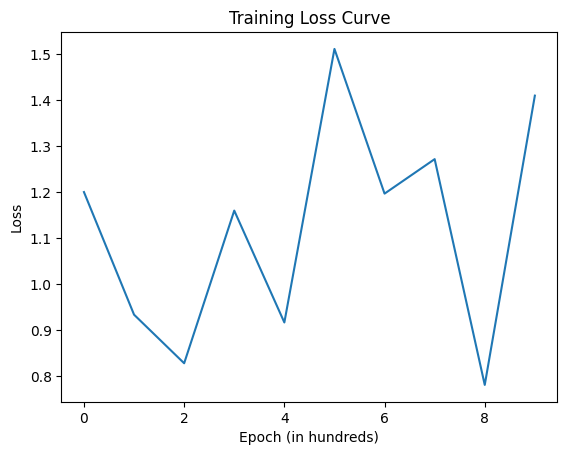

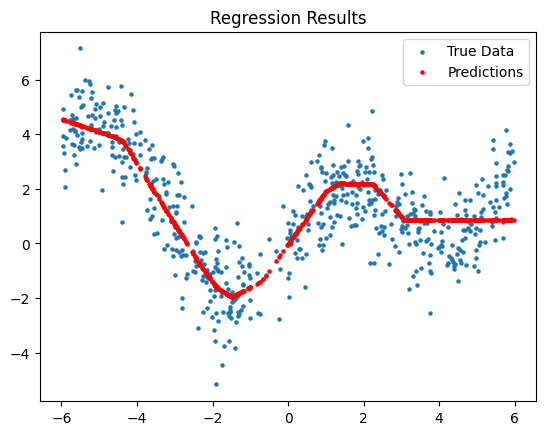

In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(42)  # for reproducibility

def generate_data(N=3000, test_ratio=0.5):
    # Calculate sizes
    test_size = int(N * test_ratio)
    train_size = N - test_size
    
    # Generate x for training data ensuring no points between -1 and 0
    train_x = torch.empty(train_size, 1)
    idx = 0
    while idx < train_size:
        sample = torch.rand(1) * 12 - 6
        if sample <= -1 or sample >= 0:
            train_x[idx] = sample
            idx += 1
    
    # Generate x for test data without any restrictions
    test_x = torch.rand(test_size) * 12 - 6
    test_x = torch.unsqueeze(test_x, dim=1)
    
    # Concatenate training and test x values
    x = torch.cat((train_x, test_x), 0)
    
    # Calculate y values for entire dataset
    y = 2 * torch.sin(x) + 0.1 * x.pow(2) + torch.normal(0, 1, size=(N, 1))
    
    # Shuffle the data
    indices = torch.randperm(N)
    shuffled_x = x[indices]
    shuffled_y = y[indices]
    
    # Split data into training and test sets
    train_x = shuffled_x[:train_size]
    train_y = shuffled_y[:train_size]
    test_x = shuffled_x[train_size:]
    test_y = shuffled_y[train_size:]
    
    return test_x, test_y, train_x, train_y

# Neural network definition
class ExtendedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ExtendedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Train the model function
def train_model(model, data_loader, criterion, optimizer, num_epochs=1000):
    losses = []
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 100 == 0:
            losses.append(loss.item())
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return losses

test_x, test_y, train_x, train_y = generate_data(N=2000, test_ratio=0.3)

# Create DataLoader for training data
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_dim = 1
hidden_dim1 = 10
hidden_dim2 = 5
output_dim = 1
model = ExtendedNN(input_dim, hidden_dim1, hidden_dim2, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

losses = train_model(model, train_loader, criterion, optimizer)

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch (in hundreds)')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Test the model
model.eval()  # set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(test_x)
    
plt.scatter(test_x, test_y, label='True Data', s=5)
plt.scatter(test_x, test_outputs, color='red', label='Predictions', s=5)
plt.legend()
plt.title('Regression Results')
plt.show()

# Testing the laplace API from Alex Immer

## Fitting and optimizing the Laplace approximation using empirical Bayes

In [2]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
n_epochs = 10000
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

/Users/noahliniger/opt/miniconda3/envs/dslab/lib/python3.9/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.ExtendedNN'> although the module has parameters
  warnings.warn(


In [153]:
x = test_x.flatten().cpu().numpy()
f_mu, f_var = la(test_x)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

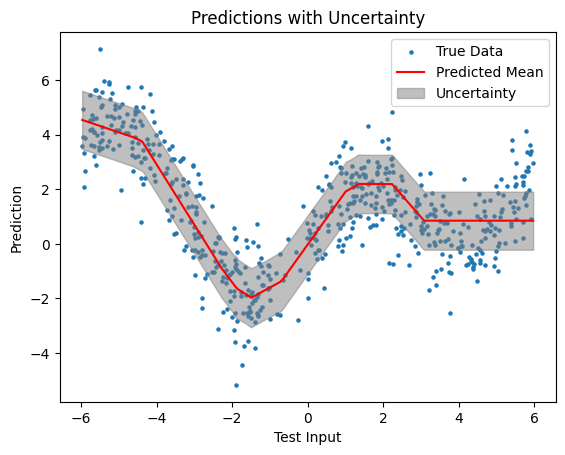

In [154]:
# Order x and apply the same ordering to f_mu and pred_std
order = np.argsort(x)
x = x[order]
f_mu = f_mu[order]
pred_std = pred_std[order]

plt.scatter(test_x, test_y, label='True Data', s=5)
plt.plot(x, f_mu, 'r-', label="Predicted Mean")
plt.fill_between(x, f_mu - pred_std, f_mu + pred_std, color='gray', alpha=0.5, label="Uncertainty")

plt.xlabel("Test Input")
plt.ylabel("Prediction")
plt.title("Predictions with Uncertainty")
plt.legend()
plt.show()

## Marginal likelyhood training

In [155]:
model2 = ExtendedNN(input_dim, hidden_dim1, hidden_dim2, output_dim)

la, model, margliks, losses = marglik_training(
    model=model2, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=400, 
    optimizer_kwargs={'lr': 1e-4}, prior_structure='scalar'
)

f_mu, f_var = la(test_x)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

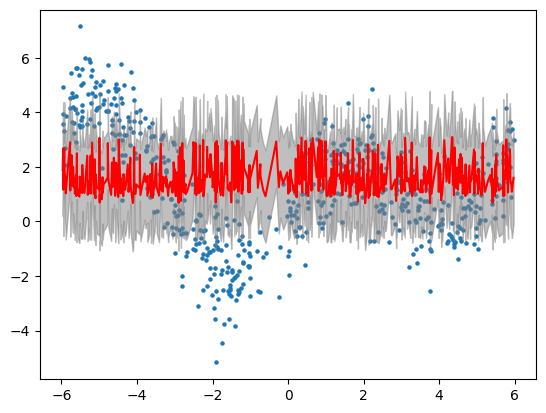

In [156]:
order = np.argsort(x)
x = x[order]
f_mu = f_mu[order]
pred_std = pred_std[order]

plt.scatter(test_x, test_y, label='True Data', s=5)
plt.plot(x, f_mu, 'r-', label="Predicted Mean")
plt.fill_between(x, f_mu - pred_std, f_mu + pred_std, color='gray', alpha=0.5, label="Uncertainty")